In [1]:
import os
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import argparse
from sklearn.model_selection import train_test_split, StratifiedKFold

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=42)  

df = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
df

CATALYST  \
0        CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...   
1        CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...   
2        CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...   
3        CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...   
4        CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...   
...                                                    ...   
2268539                                                NaN   
2268540                                                NaN   
2268541                                                NaN   
2268542                                CC(=O)[O-].O.[Cu+2]   
2268543                                                NaN   

                                                  REACTANT  \
0          CC(=O)c1ccc(Br)cc1.O=C(O)C1CCCN1C(=O)OCc1ccccc1   
1          CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCCCC1C(=O)O   
2          CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCOCC1C(=O)O   
3         CC(=O)c1ccc(Br)cc1.CC(C)C(NC(=O)OC(C)(C)C)C(=O)O   
4        CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)NC(Cc1cn(C(=O...   
...                                                    ...   
2268539  CN1CCCC1=O.COc1cc(C(=O)CO)ccc1OCCCCl.Fc1ccc2c(...   
2268540  CC(O)=S.CCOC(=O)N=NC(=O)OCC.O=C1C[C@@H](O)CN1....   
2268541  C[C@@H](O[Si](C)(C)C(C)(C)C)[C@H]1C(=O)N2C(C(=...   
2268542      C=O.CC(=O)O.CC(=O)[O-].CCOC(=O)CC(=O)OCC.[K+]   
2268543  COCC1=C(C(=O)O[C@@H](C)OC(=O)OC(C)C)N2C(=O)C(N...   

                     REAGENT        SOLVENT INTERNAL_STANDARD NoData  \
0        O=C([O-])[O-].[Cs+]       CN(C)C=O               NaN    NaN   
1        O=C([O-])[O-].[Cs+]       CN(C)C=O               NaN    NaN   
2        O=C([O-])[O-].[Cs+]       CN(C)C=O               NaN    NaN   
3        O=C([O-])[O-].[Cs+]       CN(C)C=O               NaN    NaN   
4        O=C([O-])[O-].[Cs+]       CN(C)C=O               NaN    NaN   
...                      ...            ...               ...    ...   
2268539                  NaN              O               NaN    NaN   
2268540                  NaN        C1CCOC1               NaN    NaN   
2268541                  NaN           CC#N               NaN    NaN   
2268542                  NaN            NaN               NaN    NaN   
2268543                  NaN  CCCO.CN(C)C=O               NaN    NaN   

                                        PRODUCT  YIELD   TEMP  
0        CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1   93.0   23.0  
1        CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1   82.0   23.0  
2        CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1   61.0   23.0  
3        CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1   72.0   23.0  
4        CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1   83.0   23.0  
...                                         ...    ...    ...  
2268539           CC(O)CC(=O)[O-].O=C([O-])CCCO    NaN  100.0  
2268540           CC(O)CC(=O)[O-].O=C([O-])CCCO    NaN    NaN  
2268541           CC(O)CC(=O)[O-].O=C([O-])CCCO    NaN    NaN  
2268542           O=S(=O)(c1ccc(Cl)cc1)C(F)(F)F    NaN    NaN  
2268543           CC(O)CC(=O)[O-].O=C([O-])CCCO    NaN    NaN  

[2268544 rows x 9 columns]

In [128]:
df[~df['NoData'].isna()]

CATALYST REACTANT REAGENT SOLVENT INTERNAL_STANDARD  \
73855        NaN      NaN     NaN     NaN               NaN   
73856        NaN      NaN     NaN     NaN               NaN   
73857        NaN      NaN     NaN     NaN               NaN   
73858        NaN      NaN     NaN     NaN               NaN   
73859        NaN      NaN     NaN     NaN               NaN   
...          ...      ...     ...     ...               ...   
2051384      NaN      NaN     NaN     NaN               NaN   
2051385      NaN      NaN     NaN     NaN               NaN   
2051386      NaN      NaN     NaN     NaN               NaN   
2051387      NaN      NaN     NaN     NaN               NaN   
2051388      NaN      NaN     NaN     NaN               NaN   

                                                    NoData  \
73855     C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-]   
73856                CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1   
73857    CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....   
73858    CC(C)=C(Cl)N(C)C.COCC(C)Oc1cc(Oc2cnc(C(=O)N3CC...   
73859    Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1.NCc1ccc(Cl)c(Cl)c1   
...                                                    ...   
2051384                 CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl   
2051385  CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...   
2051386  CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...   
2051387  CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....   
2051388     CC(C)(C)OC(=O)N1CCCC1CO.CCN(CC)CC.CS(=O)(=O)Cl   

                                                   PRODUCT  YIELD  TEMP  
73855                               CC(C)CC(=O)c1ccc(O)nc1    NaN   NaN  
73856                       CNc1ccc(C(=O)O)cc1[N+](=O)[O-]    NaN   NaN  
73857     CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21    NaN   NaN  
73858    COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...    NaN   NaN  
73859       Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1    NaN   NaN  
...                                                    ...    ...   ...  
2051384                           CCOc1ccccc1OC1CN(CC)CC1O    NaN   NaN  
2051385  CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC    NaN   NaN  
2051386              CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1    NaN   NaN  
2051387                      COC(=O)c1cc(Br)cc2c1ccn2C(C)C    NaN   NaN  
2051388                  CC(C)(C)OC(=O)N1CCCC1COS(C)(=O)=O    NaN   NaN  

[479035 rows x 9 columns]

In [129]:
dic = {col:i for i, col in enumerate(df.columns[:-3])}
lis = []
for key in dic.keys():
    for vals in df[key].values:
        if type(vals) == str:
            for val in vals.split('.'):
                lis.append([val, dic[key]])

In [130]:
df[~df['NoData'].isna()]

CATALYST REACTANT REAGENT SOLVENT INTERNAL_STANDARD  \
73855        NaN      NaN     NaN     NaN               NaN   
73856        NaN      NaN     NaN     NaN               NaN   
73857        NaN      NaN     NaN     NaN               NaN   
73858        NaN      NaN     NaN     NaN               NaN   
73859        NaN      NaN     NaN     NaN               NaN   
...          ...      ...     ...     ...               ...   
2051384      NaN      NaN     NaN     NaN               NaN   
2051385      NaN      NaN     NaN     NaN               NaN   
2051386      NaN      NaN     NaN     NaN               NaN   
2051387      NaN      NaN     NaN     NaN               NaN   
2051388      NaN      NaN     NaN     NaN               NaN   

                                                    NoData  \
73855     C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-]   
73856                CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1   
73857    CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....   
73858    CC(C)=C(Cl)N(C)C.COCC(C)Oc1cc(Oc2cnc(C(=O)N3CC...   
73859    Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1.NCc1ccc(Cl)c(Cl)c1   
...                                                    ...   
2051384                 CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl   
2051385  CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...   
2051386  CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...   
2051387  CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....   
2051388     CC(C)(C)OC(=O)N1CCCC1CO.CCN(CC)CC.CS(=O)(=O)Cl   

                                                   PRODUCT  YIELD  TEMP  
73855                               CC(C)CC(=O)c1ccc(O)nc1    NaN   NaN  
73856                       CNc1ccc(C(=O)O)cc1[N+](=O)[O-]    NaN   NaN  
73857     CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21    NaN   NaN  
73858    COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...    NaN   NaN  
73859       Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1    NaN   NaN  
...                                                    ...    ...   ...  
2051384                           CCOc1ccccc1OC1CN(CC)CC1O    NaN   NaN  
2051385  CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC    NaN   NaN  
2051386              CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1    NaN   NaN  
2051387                      COC(=O)c1cc(Br)cc2c1ccn2C(C)C    NaN   NaN  
2051388                  CC(C)(C)OC(=O)N1CCCC1COS(C)(=O)=O    NaN   NaN  

[479035 rows x 9 columns]

In [132]:
dic

{'CATALYST': 0,
 'REACTANT': 1,
 'REAGENT': 2,
 'SOLVENT': 3,
 'INTERNAL_STANDARD': 4,
 'NoData': 5}

In [133]:
df = pd.DataFrame(lis, columns=['smiles', 'target'])
df

smiles  target
0         CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...       0
1                     CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1       0
2                                                    COCCOC       0
3                                                  Cl[Ni]Cl       0
4                                        F[P-](F)(F)(F)(F)F       0
...                                                     ...     ...
10816419                                               [H-]       5
10816420                                              [Na+]       5
10816421                            CC(C)(C)OC(=O)N1CCCC1CO       5
10816422                                          CCN(CC)CC       5
10816423                                       CS(=O)(=O)Cl       5

[10816424 rows x 2 columns]

In [134]:
df['target'].value_counts()

1    6155626
5    2290925
3    1912075
0     419830
2      30099
4       7869
Name: target, dtype: int64

In [52]:
df = df.drop_duplicates()
df

smiles  target
0         CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...       0
1                     CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1       0
2                                                    COCCOC       0
3                                                  Cl[Ni]Cl       0
4                                        F[P-](F)(F)(F)(F)F       0
...                                                     ...     ...
10816367  CCOC(=O)c1cccc2nc(CCl)n(Cc3ccc(-c4ccccc4-c4nnn...       5
10816374                                COc1cccc2c1OC(CO)C2       5
10816396                    CC(CCCl)C(=O)Nc1cc(C(C)(C)C)ns1       5
10816408  CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...       5
10816411       Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3ccccc32)cc1       5

[1008377 rows x 2 columns]

In [24]:
df.to_csv('../../all_data_for_classification.csv', index=False)
df = df[(df['target']!=4)&(df['target']!=5)]
df['target'].value_counts()

1    678763
0      1959
3      1576
2        82
Name: target, dtype: int64

In [25]:
lis = []
for idx, row in df.iterrows():
    if row['target'] != 1:
        lis.append(0)
    else:
        lis.append(1)
df['target'] = lis
df['target'].value_counts()

1    678763
0      3617
Name: target, dtype: int64

In [21]:
df.drop_duplicates()['target'].value_counts()

1    678763
0      3119
Name: target, dtype: int64

In [26]:
df = df.drop_duplicates().reset_index(drop=True)

In [27]:
skf = StratifiedKFold(n_splits=10)
df['fold'] = -1
for fold, (tr_idx, va_idx) in enumerate(skf.split(df['smiles'], df['target'])):
    df['fold'][va_idx] = fold
df

smiles  target  fold
0       CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...       0     0
1                   CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1       0     0
2                                                  COCCOC       0     0
3                                                Cl[Ni]Cl       0     0
4                                      F[P-](F)(F)(F)(F)F       0     0
...                                                   ...     ...   ...
681877                                                FCF       0     9
681878  C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...       0     9
681879                                           O=P(=O)O       0     9
681880                                      CC(O)COC(C)CO       0     9
681881                                          BrC(Br)Br       0     9

[681882 rows x 3 columns]

In [28]:
df['fold'].value_counts()

0    68189
1    68189
2    68188
3    68188
4    68188
5    68188
6    68188
7    68188
8    68188
9    68188
Name: fold, dtype: int64

In [29]:
df.to_csv('../../data_for_classification_binary.csv', index=False)

In [2]:
df = pd.read_csv('../../classification-input-train.csv')
tokenizer = AutoTokenizer.from_pretrained('./tokenizer')

In [4]:
l = []
for i, row in df.iterrows():
    smiles = row['smiles']
    l.append(len(tokenizer(smiles).input_ids))

In [5]:
df['len'] = l
df['len'].describe()

count    613693.000000
mean         36.434748
std          18.689070
min           2.000000
25%          23.000000
50%          33.000000
75%          45.000000
max         814.000000
Name: len, dtype: float64

<AxesSubplot:>

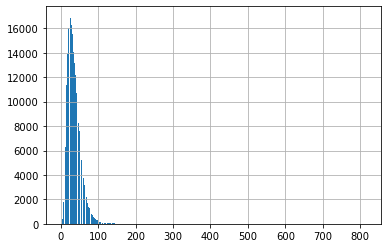

In [7]:
df['len'].hist(bins=1000)

In [2]:
# data for nodata prediction
df = pd.read_csv('../../all_data_for_classification.csv')
df

smiles  target
0        CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...       0
1                    CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1       0
2                                                   COCCOC       0
3                                                 Cl[Ni]Cl       0
4                                       F[P-](F)(F)(F)(F)F       0
...                                                    ...     ...
1008372  CCOC(=O)c1cccc2nc(CCl)n(Cc3ccc(-c4ccccc4-c4nnn...       5
1008373                                COc1cccc2c1OC(CO)C2       5
1008374                    CC(CCCl)C(=O)Nc1cc(C(C)(C)C)ns1       5
1008375  CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...       5
1008376       Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3ccccc32)cc1       5

[1008377 rows x 2 columns]

In [4]:
df[df['target'] == 5].reset_index(drop=True).to_csv('nodata.csv', index=False)

In [45]:
import pandas as pd
df = pd.read_csv('reconstructed-nodata.csv')
df

REAGENT  \
0       CC(=O)OP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1O[...   
1       CC=O.Cl[Mn]Cl.Nc1[nH]c(F)nc2ncnc1-2.O.OCCN(CCO...   
2                                  CON(C)C(=O)c1ccc(O)nc1   
3                        O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1   
4           CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21   
...                                                   ...   
479033                          CCN1CC2OC2C1.CCOc1ccccc1O   
479034  CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...   
479035  CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...   
479036                        COC(=O)c1cc(Br)cc2[nH]ccc12   
479037                            CC(C)(C)OC(=O)N1CCCC1CO   

                            REACTANT  \
0                                NaN   
1                                NaN   
2          C1CCOC1.CC(C)C[Mg+].[Cl-]   
3                               CN.O   
4                               O=CO   
...                              ...   
479033                      Cl.ClCCl   
479034             CC(=O)O.CCOC(C)=O   
479035       O=C([O-])[O-].[K+].[K+]   
479036  CC(C)I.CN(C)C=O.O.[H-].[Na+]   
479037        CCN(CC)CC.CS(=O)(=O)Cl   

                                                  PRODUCT  YIELD  TEMP  \
0                                                     NaN    NaN   NaN   
1                                                     NaN    NaN   NaN   
2                                                     NaN    NaN   NaN   
3                                                     NaN    NaN   NaN   
4                                                     NaN    NaN   NaN   
...                                                   ...    ...   ...   
479033  CC(C)C(NC(=O)OCc1ccccc1)C(=O)OCCn1cc(C(=O)OCCl...    NaN   NaN   
479034  CC(C)(C)OC(=O)N1CCN(C2=NC(=O)C(=Cc3ccc4c(cnn4C...    NaN   NaN   
479035                    CCOc1ccc(C(C)=O)cc1[N+](=O)[O-]    NaN   NaN   
479036  CCC1(c2c[nH]c3c(NS(C)(=O)=O)cccc23)CCc2cc(F)ccc21    NaN   NaN   
479037                              C=CCNC(=N)c1ccccc1.Cl    NaN   NaN   

                                                   NoData  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
479033  C1COCCO1.CC(C)C(NC(=O)OCc1ccccc1)C(=O)OCCn1cc(...  
479034  CC(C)(C)OC(=O)N1CCNC(CO)C1.CSC1=NC(=O)C(=Cc2cc...  
479035  CC(=O)c1ccc(O)c([N+](=O)[O-])c1.CCBr.CN(C)C=O....  
479036  CCC1(O)CCc2cc(F)ccc21.CS(=O)(=O)Nc1cccc2cc[nH]...  
479037                       C=CCN.CCOC(=N)c1ccccc1.CO.Cl  

[479038 rows x 6 columns]

In [50]:
import os
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import argparse
import pickle
import time
import math
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(seed=42)  


df = pd.read_csv('nodata-prediction.csv')
dic = {}
for idx, row in df.iterrows():
    dic[row['smiles']] = row['pred']
    
df_all = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
df_all = df_all[~df_all['PRODUCT'].isna()]
df_all = df_all[df_all['REACTANT'].isna()].reset_index(drop=True)

dfs = []
name2num = {'REAGENT': 0,
 'REACTANT': 1}
names = ['REAGENT', 'REACTANT']
for idx, row in df_all.iterrows():
    lis = []
    if type(row['NoData']) != str:
        lis = row[names].values.tolist()
    else:
        for name in names:
            if type(row[name]) == str:
                lis.append([row[name]])
            else:
                lis.append([])
        for smile in row['NoData'].split('.'):
            num = dic[smile]
            lis[num].append(smile)
        lis = ['.'.join(smiles) for smiles in lis]
    dfs.append(lis)

df_after = pd.DataFrame(np.array(dfs).reshape(-1, 2), columns=names).reset_index(drop=True)

def canonicalize(smi):
    smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),True)
    return smi

df_after[['PRODUCT', 'YIELD', 'TEMP', 'NoData']] = df_all[['PRODUCT', 'YIELD', 'TEMP', 'NoData']]

df_after.to_csv('reconstructed-nodata.csv', index=False)


print('finish')

finish


In [51]:
df_after

REAGENT  \
0       CC(=O)OP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1O[...   
1       CC=O.Cl[Mn]Cl.Nc1[nH]c(F)nc2ncnc1-2.O.OCCN(CCO...   
2                                  CON(C)C(=O)c1ccc(O)nc1   
3                        O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1   
4           CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21   
...                                                   ...   
479033                          CCN1CC2OC2C1.CCOc1ccccc1O   
479034  CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...   
479035  CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...   
479036                        COC(=O)c1cc(Br)cc2[nH]ccc12   
479037                            CC(C)(C)OC(=O)N1CCCC1CO   

                            REACTANT  \
0                                nan   
1                                nan   
2          C1CCOC1.CC(C)C[Mg+].[Cl-]   
3                               CN.O   
4                               O=CO   
...                              ...   
479033                      Cl.ClCCl   
479034             CC(=O)O.CCOC(C)=O   
479035       O=C([O-])[O-].[K+].[K+]   
479036  CC(C)I.CN(C)C=O.O.[H-].[Na+]   
479037        CCN(CC)CC.CS(=O)(=O)Cl   

                                                  PRODUCT  YIELD  TEMP  \
0       C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O    NaN   NaN   
1                                       C#C[C@](O)(C=O)CO   76.0  35.0   
2                                  CC(C)CC(=O)c1ccc(O)nc1    NaN   NaN   
3                          CNc1ccc(C(=O)O)cc1[N+](=O)[O-]    NaN   NaN   
4        CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21    NaN   NaN   
...                                                   ...    ...   ...   
479033                           CCOc1ccccc1OC1CN(CC)CC1O    NaN   NaN   
479034  CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC    NaN   NaN   
479035              CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1    NaN   NaN   
479036                      COC(=O)c1cc(Br)cc2c1ccn2C(C)C    NaN   NaN   
479037                  CC(C)(C)OC(=O)N1CCCC1COS(C)(=O)=O    NaN   NaN   

                                                   NoData  
0                                                     NaN  
1                                                     NaN  
2        C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-]  
3                   CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1  
4       CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....  
...                                                   ...  
479033                 CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl  
479034  CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...  
479035  CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...  
479036  CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....  
479037     CC(C)(C)OC(=O)N1CCCC1CO.CCN(CC)CC.CS(=O)(=O)Cl  

[479038 rows x 6 columns]

In [52]:
df_all

CATALYST REACTANT                                            REAGENT  \
0           NaN      NaN  CC(=O)OP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1O[...   
1           NaN      NaN  CC=O.Cl[Mn]Cl.Nc1[nH]c(F)nc2ncnc1-2.O.OCCN(CCO...   
2           NaN      NaN                                                NaN   
3           NaN      NaN                                                NaN   
4           NaN      NaN                                                NaN   
...         ...      ...                                                ...   
479033      NaN      NaN                                                NaN   
479034      NaN      NaN                                                NaN   
479035      NaN      NaN                                                NaN   
479036      NaN      NaN                                                NaN   
479037      NaN      NaN                                                NaN   

         SOLVENT INTERNAL_STANDARD  \
0              O               NaN   
1       CC(C)O.O               NaN   
2            NaN               NaN   
3            NaN               NaN   
4            NaN               NaN   
...          ...               ...   
479033       NaN               NaN   
479034       NaN               NaN   
479035       NaN               NaN   
479036       NaN               NaN   
479037       NaN               NaN   

                                                   NoData  \
0                                                     NaN   
1                                                     NaN   
2        C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-]   
3                   CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1   
4       CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....   
...                                                   ...   
479033                 CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl   
479034  CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...   
479035  CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...   
479036  CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....   
479037     CC(C)(C)OC(=O)N1CCCC1CO.CCN(CC)CC.CS(=O)(=O)Cl   

                                                  PRODUCT  YIELD  TEMP  
0       C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O    NaN   NaN  
1                                       C#C[C@](O)(C=O)CO   76.0  35.0  
2                                  CC(C)CC(=O)c1ccc(O)nc1    NaN   NaN  
3                          CNc1ccc(C(=O)O)cc1[N+](=O)[O-]    NaN   NaN  
4        CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21    NaN   NaN  
...                                                   ...    ...   ...  
479033                           CCOc1ccccc1OC1CN(CC)CC1O    NaN   NaN  
479034  CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC    NaN   NaN  
479035              CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1    NaN   NaN  
479036                      COC(=O)c1cc(Br)cc2c1ccn2C(C)C    NaN   NaN  
479037                  CC(C)(C)OC(=O)N1CCCC1COS(C)(=O)=O    NaN   NaN  

[479038 rows x 9 columns]